# Download Data

In [1]:
!gdown --id 1zl2nsDqjSjHCwVnl2d_H3BPd0_HikW3P --output hw2_data.zip
!unzip -q hw2_data.zip
!rm hw2_data.zip

Downloading...
From: https://drive.google.com/uc?id=1zl2nsDqjSjHCwVnl2d_H3BPd0_HikW3P
To: /content/hw2_data.zip
100% 642M/642M [00:03<00:00, 161MB/s]


In [14]:
!bash hw2_p3.sh ./hw2_data/digits/svhn/test 'svhn' ./predict.csv

--2021-11-21 17:04:07--  https://www.dropbox.com/s/dwjsygkcxtnxbwl/p3_svhn.ckpt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dwjsygkcxtnxbwl/p3_svhn.ckpt [following]
--2021-11-21 17:04:08--  https://www.dropbox.com/s/raw/dwjsygkcxtnxbwl/p3_svhn.ckpt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ffa6dbb5fea96278ab5bbf758.dl.dropboxusercontent.com/cd/0/inline/BaZnBVRyJ_JGsYTl23TUtMerh3uZaqW_CcBIEEJwoL4iuI6_YQX8zg8_Xxx-npJGzU3NLzx8ifEU7V_iEiLrtFeCjOHI5LZpYTIbX8ux6tj4jMcVcaM0V-SSOhAQkkH_DC4KfiUCIFCXiryDYeDwTZh0/file# [following]
--2021-11-21 17:04:08--  https://uc9ffa6dbb5fea96278ab5bbf758.dl.dropboxusercontent.com/cd/0/inline/BaZnBVRyJ_JGsYTl23TUtMerh3uZaqW_CcBIEEJwoL4iuI6_YQX8zg8_Xxx-npJGzU3NLzx8ifEU7V_iEiLr

In [ ]:
!wget https://www.dropbox.com/s/dwjsygkcxtnxbwl/p3_svhn.ckpt?dl=0 -O 2_3_model_usps_svhn_2.ckpt

--2021-11-21 14:06:47--  https://www.dropbox.com/s/dwjsygkcxtnxbwl/p3_svhn.ckpt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dwjsygkcxtnxbwl/p3_svhn.ckpt [following]
--2021-11-21 14:06:47--  https://www.dropbox.com/s/raw/dwjsygkcxtnxbwl/p3_svhn.ckpt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd84604ef02815c4f5e3f421860.dl.dropboxusercontent.com/cd/0/inline/BaZ0u758ZeQ2DsKxGe_ssTJ8ebi-5MQk0n7a81Ggigz-qCb2fEy6wYAxWVSVTE9jW_aqyIcIVGlw8xdDZVfuwABmPKFRtajKfnn7zL9_j72wh0I8fCqWpzHsiwRsCfwtNete2zfmB69v_iZ73qX9-smi/file# [following]
--2021-11-21 14:06:47--  https://ucd84604ef02815c4f5e3f421860.dl.dropboxusercontent.com/cd/0/inline/BaZ0u758ZeQ2DsKxGe_ssTJ8ebi-5MQk0n7a81Ggigz-qCb2fEy6wYAxWVSVTE9jW_aqyIcIVGlw8xdDZVfuw

In [3]:
!python hw2_3_usps_svhn.py --src usps --tgt svhn --mode 2

mode: 2, test_acc: 0.22140



# Import Packages

In [ ]:
import argparse
import glob
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch.autograd import Function
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.transforms import transforms
from tqdm.auto import tqdm

# Define Dataset

In [ ]:
class digit_dataset(data.Dataset):
    def __init__(self, inputs_path: list, labels: list, transforms):
        self.inputs_path = inputs_path
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.inputs_path)
    
    def __getitem__(self, index: int):
        
        input_path = self.inputs_path[index]
        input = Image.open(input_path)
        input = input.convert('RGB')
        label = self.labels[index]

        return self.transforms(input), label

# Random Seeds

In [ ]:
def fix_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

# Get Dataset

In [ ]:
def get_dataset(batch_size, n_workers, src_domain, tgt_domain):


    train_transforms = transforms.Compose([
        # transforms.CenterCrop((28, 24)),
        # transforms.Resize((28, 28)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        # transforms.Normalize(mean=(0.5, ), std=(0.5, )),
    ])
    
    test_transforms = transforms.Compose([
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        # transforms.Normalize(mean=(0.5, ), std=(0.5, )),
    ])

    # train_transforms = transforms.Compose([
    #     transforms.Resize((84, 84)),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # ])

    # test_transforms = transforms.Compose([
    #     transforms.Resize((84, 84)),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # ])

    # ========================== training data ==========================
    # src_train_labels_fn = f'../2_1/hw2_data/digits/{src_domain}/train.csv'
    src_train_labels_fn = f'./hw2_data/digits/{src_domain}/train.csv'
    src_train_labels = []
    with open(src_train_labels_fn, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index != 0:
                src_train_labels.append(int(line[-2]))
    
    # src_train_fn = f'../2_1/hw2_data/digits/{src_domain}/train/*'
    src_train_fn = f'./hw2_data/digits/{src_domain}/train/*'
    src_train_files = glob.glob(src_train_fn)
    src_train_files.sort()
    src_train_set = digit_dataset(src_train_files, src_train_labels, train_transforms)
    src_train_loader = DataLoader(src_train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)
    
    # tgt_train_labels_fn = f'../2_1/hw2_data/digits/{tgt_domain}/train.csv'
    tgt_train_labels_fn = f'./hw2_data/digits/{tgt_domain}/train.csv'
    tgt_train_labels = []
    with open(tgt_train_labels_fn, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index != 0:
                tgt_train_labels.append(int(line[-2]))
    
    # tgt_train_fn = f'../2_1/hw2_data/digits/{tgt_domain}/train/*'
    tgt_train_fn = f'./hw2_data/digits/{tgt_domain}/train/*'
    tgt_train_files = glob.glob(tgt_train_fn)
    # nums = [1, 6]
    # tgt_train_files = [tgt_train_file for index, tgt_train_file in enumerate(tgt_train_files) if (index % 10) in nums]
    tgt_train_files.sort()
    tgt_train_set = digit_dataset(tgt_train_files, tgt_train_labels, train_transforms)
    tgt_train_loader = DataLoader(tgt_train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

    # ========================== testing data ==========================

    # test_labels_fn = f'../2_1/hw2_data/digits/{tgt_domain}/test.csv'
    test_labels_fn = f'./hw2_data/digits/{tgt_domain}/test.csv'
    test_labels = []
    with open(test_labels_fn, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index != 0:
                test_labels.append(int(line[-2]))
    
    # test_fn = f'../2_1/hw2_data/digits/{tgt_domain}/test/*'
    test_fn = f'./hw2_data/digits/{tgt_domain}/test/*'
    test_files = glob.glob(test_fn)
    test_files.sort()
    test_set = digit_dataset(test_files, test_labels, test_transforms)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return src_train_loader, tgt_train_loader, test_loader

# Define Model

In [ ]:
class GRL(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # nn.Conv2d(32, 64, kernel_size=3),
            # nn.BatchNorm2d(64),
            # nn.MaxPool2d(2, 2),
            # nn.ReLU()
        )

        self.class_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(16, 10)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 64),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(64, 4),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.shape[0], -1)
        class_preds = self.class_classifier(x)
        reverse_x = GRL.apply(x)
        domain_preds = self.domain_classifier(reverse_x)
        return class_preds, domain_preds

class DSN(nn.Module):
    def __init__(self):
        super().__init__()
        self.src_encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.src_encoder_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 100),
            nn.ReLU()
        )

        self.tgt_encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.tgt_encoder_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 100),
            nn.ReLU()
        )

        self.shared_encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 48, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.shared_encoder_fc = nn.Sequential(
            nn.Linear(48 * 7 * 7, 100),
            nn.ReLU()
        )

        self.class_classifier = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x, domain):
        if domain == 'src':
            pri_feat = self.src_encoder_conv(x)
            pri_feat = pri_feat.view(-1, 64 * 7 * 7)
            pri_feat = self.src_encoder_fc(pri_feat)
        elif domain == 'tgt':
            pri_feat = self.tgt_encoder_conv(x)
            pri_feat = pri_feat.view(-1, 64 * 7 * 7)
            pri_feat = self.tgt_encoder_fc(pri_feat)
        
        shared_feat = self.shared_encoder_conv(x)
        shared_feat = shared_feat.view(-1, 48 * 7 * 7)
        shared_feat = self.shared_encoder_fc(shared_feat)

        class_preds = self.class_classifier(shared_feat)

        reverse_shared_feat = GRL.apply(shared_feat)
        domain_preds = self.domain_classifier(reverse_shared_feat)

        return pri_feat, shared_feat, class_preds, domain_preds

In [ ]:
a = torch.randn((1, 3))
a_norm = torch.norm(a, p=2, dim=1, keepdim=True)
print(a)
print(a / 2)
print(a / (a_norm + 1e-6))
print(a_norm)
print(torch.norm(a / (a_norm + 1e-6), p=2, dim=1, keepdim=True))


tensor([[-0.4935,  1.2503, -0.5536]])
tensor([[-0.2468,  0.6251, -0.2768]])
tensor([[-0.3395,  0.8601, -0.3808]])
tensor([[1.4537]])
tensor([[1.0000]])


# Training

In [ ]:
# def semi_supervised(device, model, threshold=0.9):
#     train_transforms = transforms.Compose([
#         # transforms.CenterCrop((28, 24)),
#         # transforms.Resize((28, 28)),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         # transforms.Normalize(mean=(0.5, ), std=(0.5, )),
#     ])

#     tgt_train_labels_fn = f'./hw2_data/digits/svhn/train.csv'
#     tgt_train_labels = []
#     with open(tgt_train_labels_fn, 'r') as f:
#         for index, line in enumerate(f.readlines()):
#             if index != 0:
#                 tgt_train_labels.append(int(line[-2]))
    
#     # tgt_train_fn = f'../2_1/hw2_data/digits/{tgt_domain}/train/*'
#     tgt_train_fn = f'./hw2_data/digits/svhn/train/*'
#     tgt_train_files = glob.glob(tgt_train_fn)
#     # nums = [1, 6]
#     # tgt_train_files = [tgt_train_file for index, tgt_train_file in enumerate(tgt_train_files) if (index % 10) in nums]
#     tgt_train_files.sort()
#     tgt_train_set = digit_dataset(tgt_train_files, tgt_train_labels, train_transforms)

#     # -----------------------------------------------------------------------------

#     tgt_train_loader = DataLoader(tgt_train_set, batch_size=batch_size, shuffle=False)
#     new_fns = tgt_train_files
#     new_labels = tgt_train_labels
#     softmax = nn.Softmax()
#     batch_idx = 0
#     for batch in tqdm(tgt_train_loader):
#     # for batch_idx, batch in enumerate(tgt_train_loader):
#         tgt_imgs, _ = batch
#         tgt_imgs = tgt_imgs.to(device)
        
#         preds, _ = model(tgt_imgs)
#         # print(preds)
#         # print(preds.shape)
#         probs = softmax(preds)
#         indices = (probs > threshold).nonzero(as_tuple=False)
        
#         fns = [f'./hw2_data/digits/svhn/train/{(batch_size * batch_idx + index[0].item()):05d}.png' for index in indices]
#         new_fns = new_fns + fns
        
#         labels = [index[1].item() for index in indices]
#         new_labels = new_labels + labels
        
#         batch_idx += 1
#     new_dataset = digit_dataset(new_fns, new_labels, train_transforms)
#     new_dataloader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)
#     return new_dataloader

def diffloss(vec_1, vec_2):
    vec_1_norm = torch.norm(vec_1, p=2, dim=1, keepdim=True).detach()
    vec_1 = vec_1 / (vec_1_norm + 1e-6)

    vec_2_norm = torch.norm(vec_2, p=2, dim=1, keepdim=True).detach()
    vec_2 = vec_2 / (vec_2_norm + 1e-6)

    return torch.mean((vec_1.t().mm(vec_2)).pow(2))

def train(device, src_train_loader, tgt_train_loader, start_epoch, n_epochs, model, optim, mode, src_domain, tgt_domain):

    # =============================== classifier on source domain ===============================
    if mode == 1:
        
        loss_fn = nn.CrossEntropyLoss()
        max_train_acc = 0

        for epoch in range(start_epoch, n_epochs):
            
            model.train()

            # train
            # batch_idx = 0
            losses = []
            accs = []
            for batch in tqdm(src_train_loader):
            
            # for batch_idx, batch in enumerate(src_train_loader):
                
                src_imgs, src_labels = batch
                src_imgs = src_imgs.to(device)
                src_labels = src_labels.to(device)

                src_feats, shared_feats, class_preds, domain_preds = model(src_imgs, domain='src')
                
                loss = loss_fn(src_preds, src_labels)
                losses.append(loss.item())
                accs.append((src_preds.argmax(dim=1) == src_labels).float().mean())

                optim.zero_grad()
                loss.backward()
                optim.step()

                # batch_idx += 1
            loss = sum(losses) / len(losses)
            acc = sum(accs) / len(accs)

            with open(record_fn, 'a') as f:
                f.write(f'[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss: {loss:.5f} acc: {acc:.5f}\n')

            # save checkpoint
            if max_train_acc < acc:
                max_train_acc = acc
                torch.save({'last_epoch': epoch + 1,
                            'model': model.state_dict(),
                            'optim': optim.state_dict(),
                            # 'scheduler': scheduler.state_dict(),
                            }, f'./2_3_model_{src_domain}_{tgt_domain}_1.ckpt')
                with open(record_fn, 'a') as f:
                    f.write(f'Saving 2_3_model_{src_domain}_{tgt_domain}_1.ckpt\n')

    # =============================== DANN ===============================
    elif mode == 2:
        
        class_loss_fn = nn.CrossEntropyLoss()
        domain_loss_fn = nn.BCELoss()
        max_train_acc = 0

        for epoch in range(start_epoch, n_epochs):
            
            model.train()
            # if epoch > 0:
            #   src_train_loader = semi_supervised(device, model)

            # train
            # batch_idx = 0
            # losses = []
            accs = []
            for batch in tqdm(src_train_loader):
            
            # for batch_idx, batch in enumerate(src_train_loader):
            
                src_imgs, src_labels = batch
                bs = src_imgs.shape[0]
                src_imgs = src_imgs.to(device)
                src_labels = src_labels.to(device)
                src_domain_labels = torch.ones((bs, 1)).to(device)

                src_feats, shared_feats, class_preds, domain_preds = model(src_imgs, domain='src')
                
                loss = class_loss_fn(class_preds, src_labels) + domain_loss_fn(domain_preds, src_domain_labels) + diffloss(src_feats, shared_feats)
                # losses.append(loss.item())
                accs.append((class_preds.argmax(dim=1) == src_labels).float().mean())

                optim.zero_grad()
                loss.backward()
                optim.step()

                # batch_idx += 1
            # loss = sum(losses) / len(losses)
            acc = sum(accs) / len(accs)
            for batch in tqdm(tgt_train_loader):
            # for batch_idx, batch in enumerate(tgt_train_loader):

                tgt_imgs, tgt_labels = batch
                bs = tgt_imgs.shape[0]
                tgt_imgs = tgt_imgs.to(device)
                tgt_labels = tgt_labels.to(device)
                tgt_domain_labels = torch.zeros((bs, 1)).to(device)

                tgt_feats, shared_feats, _, domain_preds = model(tgt_imgs, domain='tgt')

                loss = domain_loss_fn(domain_preds, tgt_domain_labels) + diffloss(tgt_feats, shared_feats)

                optim.zero_grad()
                loss.backward()
                optim.step()

            with open(record_fn, 'a') as f:
                f.write(f'[ Train | {epoch + 1:03d}/{n_epochs:03d} ] acc: {acc:.5f}\n')

            # save checkpoint
            if max_train_acc < acc:
                max_train_acc = acc
                torch.save({'last_epoch': epoch + 1,
                            'model': model.state_dict(),
                            'optim': optim.state_dict(),
                            # 'scheduler': scheduler.state_dict(),
                            }, f'./2_3_model_{src_domain}_{tgt_domain}_2.ckpt')
                with open(record_fn, 'a') as f:
                    f.write(f'Saving 2_3_model_{src_domain}_{tgt_domain}_2.ckpt\n')
            with torch.no_grad():
                # load checkpoint
                # ckpt = torch.load(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt', map_location='cpu')
                # model.load_state_dict(ckpt['model'])
                model.eval()

                accs = []
                
                for batch in tqdm(test_loader):
                # for batch_idx, batch in enumerate(test_loader):
                    
                    tgt_imgs, tgt_labels = batch
                    tgt_imgs = tgt_imgs.to(device)
                    tgt_labels = tgt_labels.to(device)

                    _, _, tgt_preds, _ = model(tgt_imgs, domain='tgt')
                    
                    accs.append((tgt_preds.argmax(dim=1) == tgt_labels).float().mean())

                acc = sum(accs) / len(accs)
                print(f'mode: {mode}, test_acc: {acc:.5f}\n')

    # =============================== classifier on target domain ===============================
    elif mode == 3:
        
        loss_fn = nn.CrossEntropyLoss()
        max_train_acc = 0

        for epoch in range(start_epoch, n_epochs):
            
            model.train()

            # train
            # batch_idx = 0
            losses = []
            accs = []
            # for batch in tqdm(tgt_train_loader):
            
            for batch_idx, batch in enumerate(tgt_train_loader):
                
                tgt_imgs, tgt_labels = batch
                tgt_imgs = tgt_imgs.to(device)
                tgt_labels = tgt_labels.to(device)

                tgt_preds, _ = model(tgt_imgs)
                
                loss = loss_fn(tgt_preds, tgt_labels)
                losses.append(loss.item())
                accs.append((tgt_preds.argmax(dim=1) == tgt_labels).float().mean())

                optim.zero_grad()
                loss.backward()
                optim.step()

                # batch_idx += 1
            loss = sum(losses) / len(losses)
            acc = sum(accs) / len(accs)

            with open(record_fn, 'a') as f:
                f.write(f'[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss: {loss:.5f} acc: {acc:.5f}\n')

            # save checkpoint
            if max_train_acc < acc:
                max_train_acc = acc
                torch.save({'last_epoch': epoch + 1,
                            'model': model.state_dict(),
                            'optim': optim.state_dict(),
                            # 'scheduler': scheduler.state_dict(),
                            }, f'./2_3_model_{src_domain}_{tgt_domain}_3.ckpt')
                with open(record_fn, 'a') as f:
                    f.write(f'Saving 2_3_model_{src_domain}_{tgt_domain}_3.ckpt\n')

# Testing

In [ ]:
def test(device, test_loader, model, mode, src_domain, tgt_domain):

    with torch.no_grad():
        # load checkpoint
        ckpt = torch.load(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt', map_location='cpu')
        model.load_state_dict(ckpt['model'])
        model.eval()

        accs = []
        
        for batch_idx, batch in enumerate(test_loader):
            
            tgt_imgs, tgt_labels = batch
            tgt_imgs = tgt_imgs.to(device)
            tgt_labels = tgt_labels.to(device)

            tgt_preds, _ = model(tgt_imgs)
            
            accs.append((tgt_preds.argmax(dim=1) == tgt_labels).float().mean())

        acc = sum(accs) / len(accs)
        with open(record_fn, 'a') as f:
            f.write(f'test_acc: {acc:.5f}\n')
        print(f'mode: {mode}, test_acc: {acc:.5f}\n')

# Run Code

In [ ]:
src_domain = 'usps'
tgt_domain = 'svhn'
mode = 2
record_fn = f'./record_{src_domain}_{tgt_domain}_{mode}.txt'
# set seed
seed = 0
fix_random_seeds(seed)

# settings
device = "cuda" if torch.cuda.is_available() else "cpu"
with open('./check.txt', 'w') as f:
    f.write(f'{device}\n')
n_workers = 0
batch_size = 32

n_epochs = 40

start_epoch = 0
model = DSN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

if not os.path.exists(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt'):
    with open(record_fn, 'w') as f:
        f.write('')
# if mode == 'train'

src_train_loader, tgt_train_loader, test_loader = get_dataset(batch_size, n_workers, src_domain, tgt_domain)

# for mode in range(1, 4):

load_model = os.path.exists(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt')
if load_model:
    ckpt = torch.load(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt', map_location='cpu')
    start_epoch = ckpt['last_epoch']
    model.load_state_dict(ckpt['model'])
    optim.load_state_dict(ckpt['optim'])

else:
    start_epoch = 0
    model = DSN().to(device)
    optim = torch.optim.Adam(model.parameters())

with open(record_fn, 'a') as f:
    f.write(f'start training mode {mode}\n')


train(device, src_train_loader, tgt_train_loader, start_epoch, n_epochs, model, optim, mode, src_domain, tgt_domain)
test(device, test_loader, model, mode, src_domain, tgt_domain)

with open(record_fn, 'a') as f:
    f.write(f'finish training mode {mode}\n')

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/2290 [00:00<?, ?it/s]

  0%|          | 0/814 [00:00<?, ?it/s]

mode: 2, test_acc: 0.14016



  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/2290 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Test

In [ ]:
!python hw2_3.py --src svhn --tgt mnistm

In [ ]:
!python hw2_3.py --src mnistm --tgt usps

In [ ]:
!python hw2_3.py --src usps --tgt svhn --mode 2

Traceback (most recent call last):
  File "hw2_3.py", line 564, in <module>
    train(device, src_train_loader, tgt_train_loader, start_epoch, n_epochs, model, optim, mode, src_domain, tgt_domain)
  File "hw2_3.py", line 415, in train
    for batch_idx, batch in enumerate(test_loader):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 561, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "hw2_3.py", line 35, in __getitem__
    input = input.convert('RGB')
  File "/usr/local/lib/

# t-SNE

In [ ]:
import argparse
import glob
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch.autograd import Function
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.transforms import transforms

class digit_dataset(data.Dataset):
    def __init__(self, inputs_path: list, labels: list, transforms):
        self.inputs_path = inputs_path
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.inputs_path)
    
    def __getitem__(self, index: int):
        
        input_path = self.inputs_path[index]
        input = Image.open(input_path)
        input = input.convert('RGB')
        label = self.labels[index]

        return self.transforms(input), label

def fix_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

def get_dataset(batch_size, n_workers, src_domain, tgt_domain):
    
    test_transforms = transforms.Compose([
        # transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])

    src_labels_fn = f'./hw2_data/digits/{src_domain}/test.csv'
    src_labels = []
    with open(src_labels_fn, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index != 0:
                src_labels.append(int(line[-2]))
    
    src_test_fn = f'./hw2_data/digits/{src_domain}/test/*'
    src_files = glob.glob(src_test_fn)
    src_files.sort()
    src_set = digit_dataset(src_files, src_labels, test_transforms)
    src_loader = DataLoader(src_set, batch_size=batch_size, shuffle=False)

    test_labels_fn = f'./hw2_data/digits/{tgt_domain}/test.csv'
    test_labels = []
    with open(test_labels_fn, 'r') as f:
        for index, line in enumerate(f.readlines()):
            if index != 0:
                test_labels.append(int(line[-2]))
    
    # test_fn = f'../2_1/hw2_data/digits/{tgt_domain}/test/*'
    test_fn = f'./hw2_data/digits/{tgt_domain}/test/*'
    test_files = glob.glob(test_fn)
    test_files.sort()
    test_set = digit_dataset(test_files, test_labels, test_transforms)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return src_loader, test_loader

class GRL(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg()

class DANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.ReLU()
        )

        self.class_classifier = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(),
            
            nn.Linear(16, 10)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x, tsne=False):
        x = self.feature_extractor(x)
        x = x.view(x.shape[0], -1)
        class_preds = self.class_classifier(x)
        reverse_x = GRL.apply(x)
        domain_preds = self.domain_classifier(reverse_x)
        if tsne:
          return x
        else:
          return class_preds, domain_preds

In [ ]:
src_domain = 'usps'
tgt_domain = 'svhn'
mode = 2
record_fn = f'./record_{src_domain}_{tgt_domain}.txt'
# set seed
seed = 0
fix_random_seeds(seed)

# settings
device = "cuda" if torch.cuda.is_available() else "cpu"
n_workers = 0
batch_size = 1
n_epochs = 100

start_epoch = 0
model = DANN().to(device)
optim = torch.optim.Adam(model.parameters())

if not os.path.exists(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt'):
    with open(record_fn, 'w') as f:
        f.write('')
# if mode == 'train'

src_loader, tgt_loader = get_dataset(batch_size, n_workers, src_domain, tgt_domain)

# for mode in range(1, 4):

load_model = os.path.exists(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt')
if load_model:
    ckpt = torch.load(f'./2_3_model_{src_domain}_{tgt_domain}_{mode}.ckpt', map_location='cpu')
    start_epoch = ckpt['last_epoch']
    model.load_state_dict(ckpt['model'])
    optim.load_state_dict(ckpt['optim'])

else:
    start_epoch = 0
    model = DANN().to(device)
    optim = torch.optim.Adam(model.parameters())

In [ ]:
src_feats = []
tgt_feats = []
model.eval()
domain = False
with torch.no_grad():
  for batch in src_loader:
      src_imgs, src_labels = batch
      if domain:
          src_feats.append([model(src_imgs.to(device), tsne=True).cpu().numpy(), 1])
      else:
          src_feats.append([model(src_imgs.to(device), tsne=True).cpu().numpy(), src_labels.item()])
  for batch in tgt_loader:
      tgt_imgs, tgt_labels = batch
      if domain:
          tgt_feats.append([model(tgt_imgs.to(device), tsne=True).cpu().numpy(), 0])
      else:
          tgt_feats.append([model(tgt_imgs.to(device), tsne=True).cpu().numpy(), tgt_labels.item()])
feats = np.squeeze(np.array([src_feat[0] for src_feat in src_feats] + [tgt_feat[0] for tgt_feat in tgt_feats]))
label = [src_feat[1] for src_feat in src_feats] + [tgt_feat[1] for tgt_feat in tgt_feats]

In [ ]:
print(feats.shape)

(28039, 64)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

feats_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(feats)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28039 samples in 0.003s...
[t-SNE] Computed neighbors for 28039 samples in 19.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28039
[t-SNE] Computed conditional probabilities for sample 2000 / 28039
[t-SNE] Computed conditional probabilities for sample 3000 / 28039
[t-SNE] Computed conditional probabilities for sample 4000 / 28039
[t-SNE] Computed conditional probabilities for sample 5000 / 28039
[t-SNE] Computed conditional probabilities for sample 6000 / 28039
[t-SNE] Computed conditional probabilities for sample 7000 / 28039
[t-SNE] Computed conditional probabilities for sample 8000 / 28039
[t-SNE] Computed conditional probabilities for sample 9000 / 28039
[t-SNE] Computed conditional probabilities for sample 10000 / 28039
[t-SNE] Computed conditional probabilities for sample 11000 / 28039
[t-SNE] Computed conditional probabilities for sample 12000 / 28039
[t-SNE] Computed conditional probabilities for sa

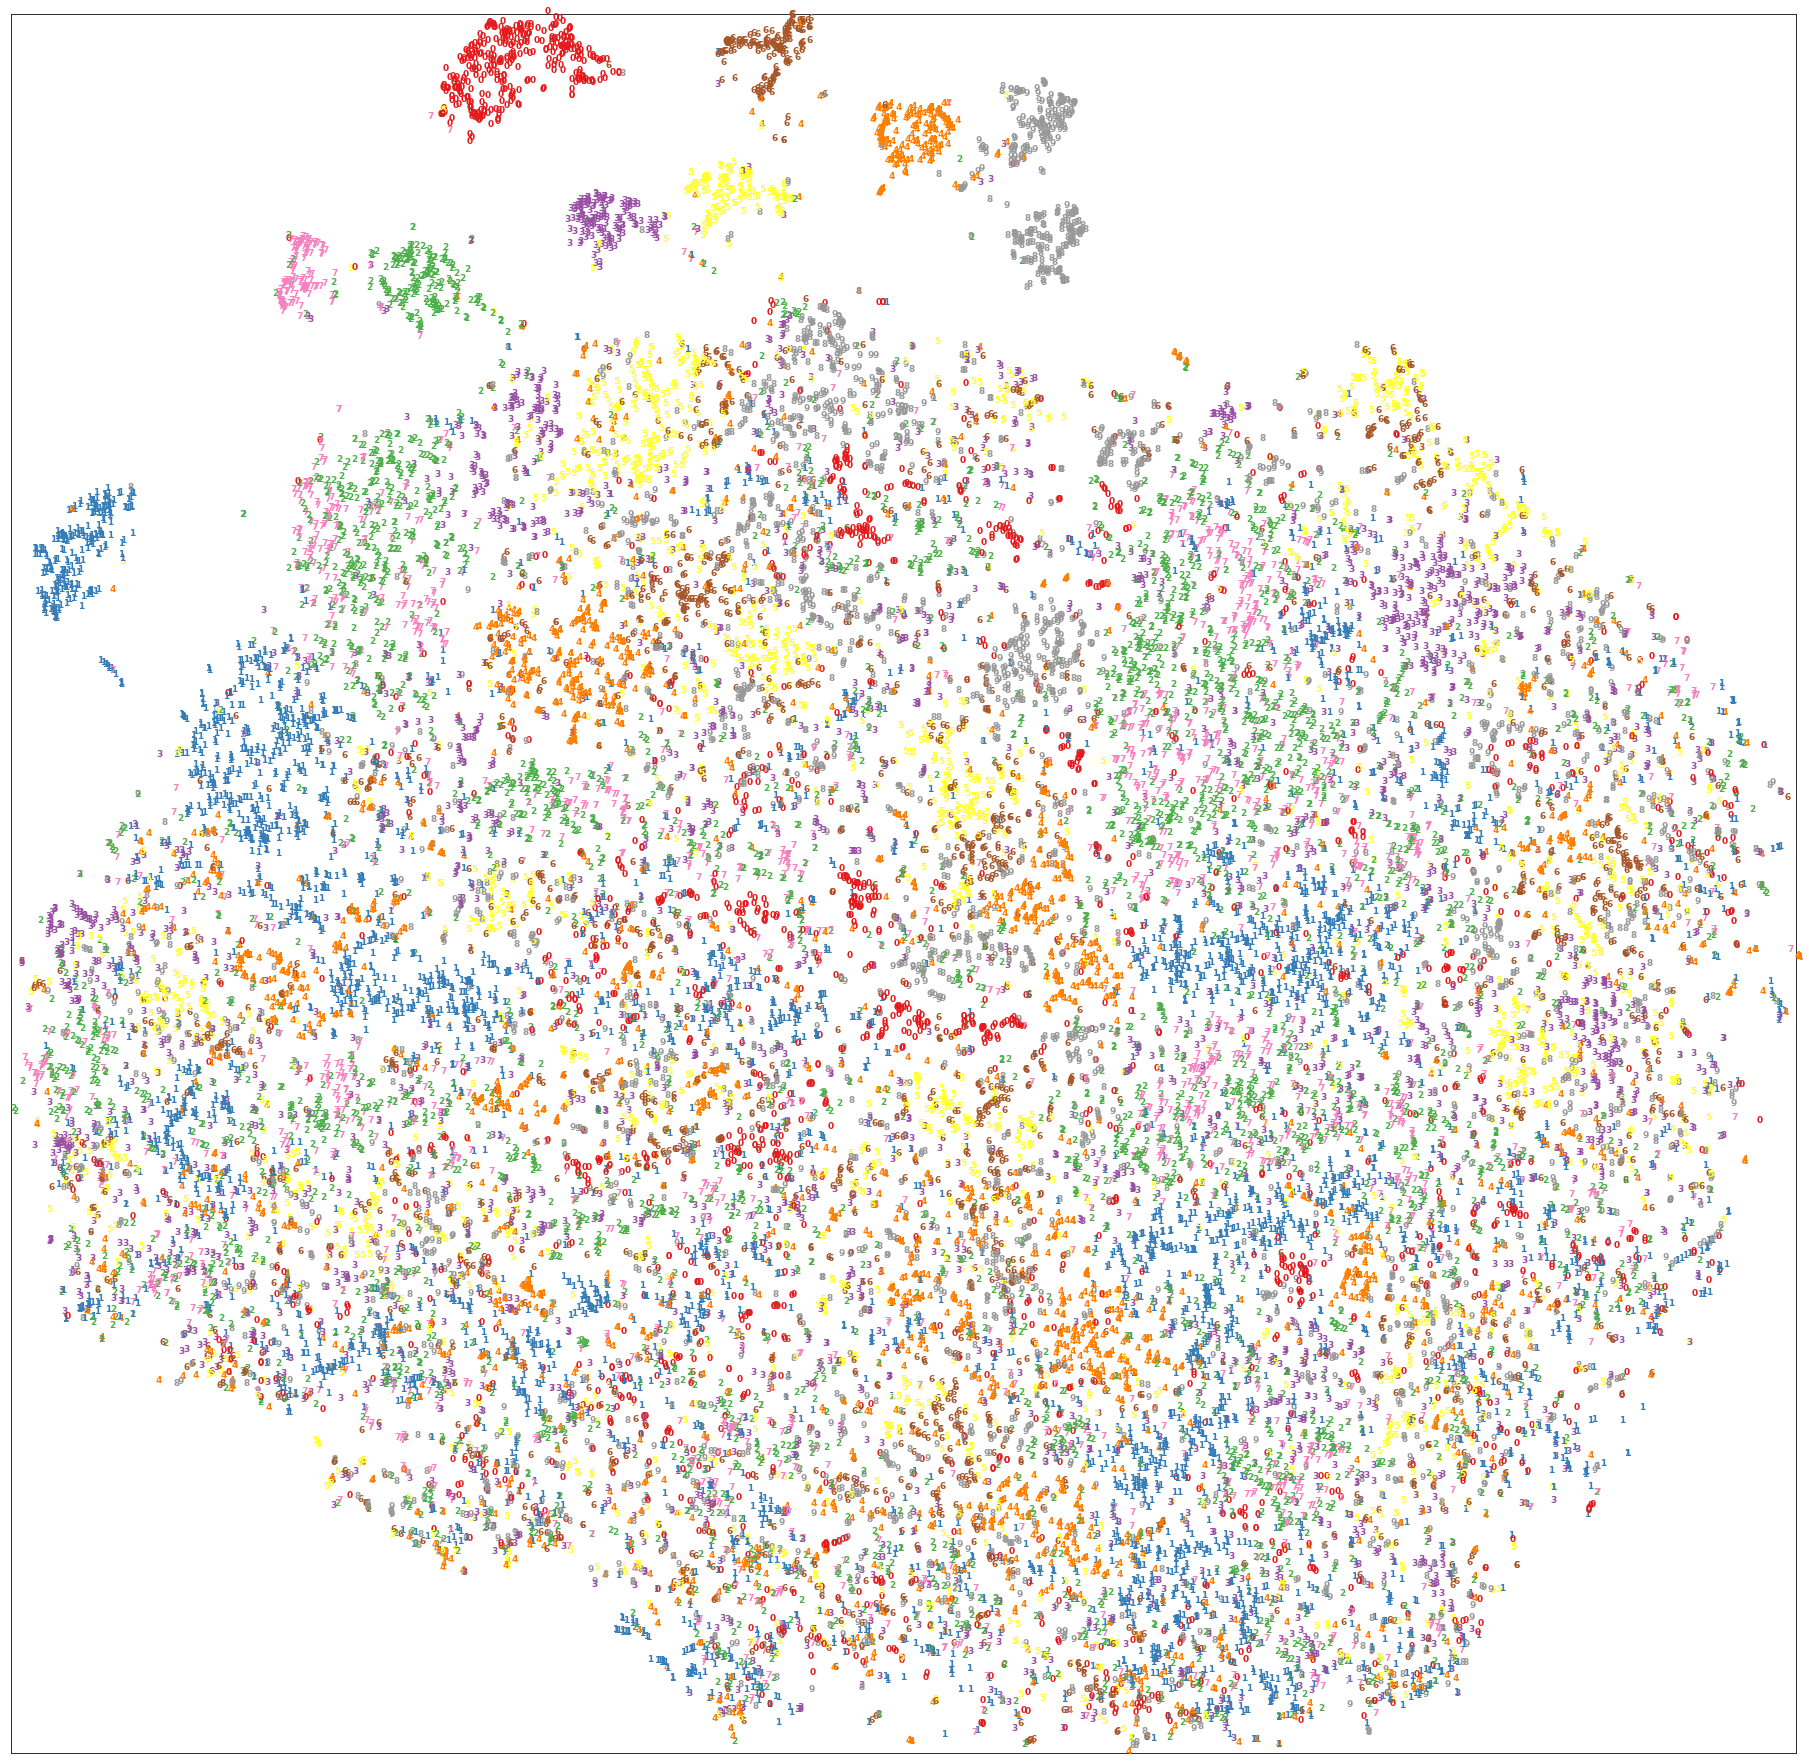

In [ ]:
# Data Visualization
feats_min, feats_max = feats_tsne.min(0), feats_tsne.max(0)
# Normalize
feats_norm = (feats_tsne - feats_min) / (feats_max - feats_min)
plt.figure(figsize=(32, 32))
for i in range(feats_norm.shape[0]):
    plt.text(feats_norm[i, 0], feats_norm[i, 1], str(label[i]), color=plt.cm.Set1(label[i]), fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.show()